In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import keras
import os
import tensorboard
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Input, Concatenate
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorboard.plugins.hparams import api as hp

from photoz_utils import *
from DataMaker import *

In [2]:
IMAGE_SHAPE = (5, 127, 127)
GB_LIMIT = 5

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(GB_LIMIT*1000)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
NUM_DENSE_UNITS = 200
BATCH_SIZE = 256
NUM_EPOCHS = 1000
LEARNING_RATE = 0.0001
hparams = {
    'num_dense_units': NUM_DENSE_UNITS,
    'batch_size': BATCH_SIZE,
    'num_epochs': NUM_EPOCHS,
    'learning_rate': LEARNING_RATE
}

In [5]:
TRAIN_PATH = '/data/HSC/HSC_v6/step2A/127x127/five_band_image127x127_with_metadata_corrected_training.hdf5'
VAL_PATH = '/data/HSC/HSC_v6/step2A/127x127/five_band_image127x127_with_metadata_corrected_validation.hdf5'
TEST_PATH = '/data/HSC/HSC_v6/step2A/127x127/five_band_image127x127_with_metadata_corrected_testing.hdf5'

In [6]:
column_names = ['object_id', 'specz_redshift', 'g_cmodel_mag', 'r_cmodel_mag', 'i_cmodel_mag', 'z_cmodel_mag', 'y_cmodel_mag']
with h5py.File(TRAIN_PATH, 'r') as hf:
    train_df = pd.DataFrame()
    for name in column_names:
        train_df[name] = hf[name][:]
    
with h5py.File(VAL_PATH, 'r') as hf:
    val_df = pd.DataFrame()
    for name in column_names:
        val_df[name] = hf[name][:]
    
with h5py.File(TEST_PATH, 'r') as hf:
    test_df = pd.DataFrame()
    for name in column_names:
        test_df[name] = hf[name][:]

In [7]:
mags = ['g_cmodel_mag', 'r_cmodel_mag', 'i_cmodel_mag', 'z_cmodel_mag', 'y_cmodel_mag']
X_train, X_val, X_test = train_df[mags], val_df[mags], test_df[mags]
y_train, y_val, y_test = train_df['specz_redshift'], val_df['specz_redshift'], test_df['specz_redshift']
OID_train, OID_val, OID_test = train_df['object_id'], val_df['object_id'], test_df['object_id']

In [8]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

In [9]:
# for now, only run the NN architecture
# add callbacks

In [10]:
import keras.backend as K

def calculate_loss(z_photo, z_spec):
    """
    HSC METRIC. Returns an array. Loss is accuracy metric defined by HSC, meant
    to capture the effects of bias, scatter, and outlier all in one. This has
    uses for both point and density estimation.
    z_photo: array
        Photometric or predicted redshifts.
    z_spec: array
        Spectroscopic or actual redshifts.
    """
    dz = delz(z_photo, z_spec)
    gamma = 0.15
    denominator = 1.0 + K.square(dz/gamma)
    loss = 1 - 1.0 / denominator
    return loss

In [11]:
input_nn = Input(shape=X_train.shape[1:])
hidden1 = Dense(hparams['num_dense_units'], activation="relu")(input_nn)
hidden2 = Dense(hparams['num_dense_units'], activation="relu")(hidden1)
hidden3 = Dense(hparams['num_dense_units'], activation="relu")(hidden2)
hidden4 = Dense(hparams['num_dense_units'], activation="relu")(hidden3)

concat = Concatenate()([input_nn, hidden4])
distribution_params = Dense(units=2)(concat)
output = tfp.layers.IndependentNormal(1)(distribution_params)
model = Model(inputs=[input_nn], outputs=[output])

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 200)          1200        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 200)          40200       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 200)          40200       dense_1[0][0]                    
______________________________________________________________________________________________

In [13]:
model.compile(optimizer=Adam(learning_rate=hparams['learning_rate']), loss=calculate_loss, metrics='mse')

In [14]:
model_name = 'HSC_v6_NN_neurips_test_v3'

checkpoint_filepath = os.path.join('/models/', model_name)+'/'+model_name
log_dir = os.path.join('/logs/', model_name)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='loss',
    mode='max',
    save_freq='epoch',
    save_best_only=True)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

hparam_callback = hp.KerasCallback(log_dir, hparams)

In [15]:
model.fit(X_train, y_train, batch_size=hparams['batch_size'], epochs=hparams['num_epochs'], shuffle=True, verbose=1, validation_data=(X_val, y_val), callbacks=[tensorboard_callback, model_checkpoint_callback, hparam_callback])

Epoch 1/1000
784/784 [==============================] - 3s 3ms/step - loss: 0.2406 - mse: 0.2452 - val_loss: 0.1535 - val_mse: 0.1405
Epoch 2/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.1473 - mse: 0.1461 - val_loss: 0.1468 - val_mse: 0.1402
Epoch 3/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.1406 - mse: 0.1419 - val_loss: 0.1363 - val_mse: 0.1331
Epoch 4/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.1362 - mse: 0.1390 - val_loss: 0.1326 - val_mse: 0.1309
Epoch 5/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.1329 - mse: 0.1371 - val_loss: 0.1309 - val_mse: 0.1298
Epoch 6/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.1304 - mse: 0.1344 - val_loss: 0.1302 - val_mse: 0.1314
Epoch 7/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.1270 - mse: 0.1318 - val_loss: 0.1283 - val_mse: 0.1244
Epoch 8/1000
784/784 [==============================] - 2s 2ms

Epoch 62/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0980 - mse: 0.1211 - val_loss: 0.0975 - val_mse: 0.1143
Epoch 63/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0980 - mse: 0.1214 - val_loss: 0.0980 - val_mse: 0.1187
Epoch 64/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0977 - mse: 0.1217 - val_loss: 0.0985 - val_mse: 0.1191
Epoch 65/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0975 - mse: 0.1210 - val_loss: 0.0983 - val_mse: 0.1164
Epoch 66/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0975 - mse: 0.1214 - val_loss: 0.0966 - val_mse: 0.1152
Epoch 67/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0975 - mse: 0.1211 - val_loss: 0.0968 - val_mse: 0.1155
Epoch 68/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0973 - mse: 0.1208 - val_loss: 0.0975 - val_mse: 0.1148
Epoch 69/1000
784/784 [==============================] 

784/784 [==============================] - 2s 2ms/step - loss: 0.0925 - mse: 0.1203 - val_loss: 0.0935 - val_mse: 0.1177
Epoch 123/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0922 - mse: 0.1206 - val_loss: 0.0932 - val_mse: 0.1142
Epoch 124/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0923 - mse: 0.1204 - val_loss: 0.0933 - val_mse: 0.1166
Epoch 125/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0922 - mse: 0.1202 - val_loss: 0.0932 - val_mse: 0.1163
Epoch 126/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0921 - mse: 0.1203 - val_loss: 0.0940 - val_mse: 0.1165
Epoch 127/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0924 - mse: 0.1204 - val_loss: 0.0935 - val_mse: 0.1160
Epoch 128/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0920 - mse: 0.1203 - val_loss: 0.0933 - val_mse: 0.1187
Epoch 129/1000
784/784 [==============================] - 2s 2m

784/784 [==============================] - 2s 2ms/step - loss: 0.0893 - mse: 0.1183 - val_loss: 0.0916 - val_mse: 0.1108
Epoch 183/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0894 - mse: 0.1183 - val_loss: 0.0914 - val_mse: 0.1172
Epoch 184/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0892 - mse: 0.1181 - val_loss: 0.0916 - val_mse: 0.1145
Epoch 185/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0893 - mse: 0.1181 - val_loss: 0.0908 - val_mse: 0.1118
Epoch 186/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0891 - mse: 0.1176 - val_loss: 0.0915 - val_mse: 0.1129
Epoch 187/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0891 - mse: 0.1183 - val_loss: 0.0915 - val_mse: 0.1112
Epoch 188/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0891 - mse: 0.1173 - val_loss: 0.0911 - val_mse: 0.1134
Epoch 189/1000
784/784 [==============================] - 2s 2m

784/784 [==============================] - 2s 2ms/step - loss: 0.0869 - mse: 0.1154 - val_loss: 0.0904 - val_mse: 0.1152
Epoch 243/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0871 - mse: 0.1150 - val_loss: 0.0902 - val_mse: 0.1097
Epoch 244/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0869 - mse: 0.1146 - val_loss: 0.0900 - val_mse: 0.1134
Epoch 245/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0871 - mse: 0.1157 - val_loss: 0.0898 - val_mse: 0.1102
Epoch 246/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0869 - mse: 0.1146 - val_loss: 0.0894 - val_mse: 0.1144
Epoch 247/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0868 - mse: 0.1152 - val_loss: 0.0902 - val_mse: 0.1124
Epoch 248/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0869 - mse: 0.1157 - val_loss: 0.0895 - val_mse: 0.1132
Epoch 249/1000
784/784 [==============================] - 2s 2m

784/784 [==============================] - 2s 2ms/step - loss: 0.0854 - mse: 0.1132 - val_loss: 0.0893 - val_mse: 0.1103
Epoch 303/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0853 - mse: 0.1127 - val_loss: 0.0890 - val_mse: 0.1087
Epoch 304/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0850 - mse: 0.1124 - val_loss: 0.0895 - val_mse: 0.1126
Epoch 305/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0855 - mse: 0.1136 - val_loss: 0.0900 - val_mse: 0.1138
Epoch 306/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0851 - mse: 0.1120 - val_loss: 0.0889 - val_mse: 0.1087
Epoch 307/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0852 - mse: 0.1122 - val_loss: 0.0895 - val_mse: 0.1080
Epoch 308/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0849 - mse: 0.1123 - val_loss: 0.0899 - val_mse: 0.1106
Epoch 309/1000
784/784 [==============================] - 2s 2m

784/784 [==============================] - 2s 2ms/step - loss: 0.0840 - mse: 0.1101 - val_loss: 0.0895 - val_mse: 0.1101
Epoch 363/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0838 - mse: 0.1109 - val_loss: 0.0897 - val_mse: 0.1113
Epoch 364/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0840 - mse: 0.1112 - val_loss: 0.0894 - val_mse: 0.1087
Epoch 365/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0840 - mse: 0.1108 - val_loss: 0.0887 - val_mse: 0.1103
Epoch 366/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0836 - mse: 0.1106 - val_loss: 0.0896 - val_mse: 0.1104
Epoch 367/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0838 - mse: 0.1107 - val_loss: 0.0889 - val_mse: 0.1088
Epoch 368/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0839 - mse: 0.1117 - val_loss: 0.0894 - val_mse: 0.1110
Epoch 369/1000
784/784 [==============================] - 2s 2m

784/784 [==============================] - 2s 2ms/step - loss: 0.0827 - mse: 0.1102 - val_loss: 0.0889 - val_mse: 0.1087
Epoch 423/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0825 - mse: 0.1092 - val_loss: 0.0888 - val_mse: 0.1084
Epoch 424/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0825 - mse: 0.1091 - val_loss: 0.0894 - val_mse: 0.1091
Epoch 425/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0825 - mse: 0.1093 - val_loss: 0.0891 - val_mse: 0.1075
Epoch 426/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0824 - mse: 0.1083 - val_loss: 0.0893 - val_mse: 0.1094
Epoch 427/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0824 - mse: 0.1088 - val_loss: 0.0893 - val_mse: 0.1092
Epoch 428/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0824 - mse: 0.1094 - val_loss: 0.0894 - val_mse: 0.1082
Epoch 429/1000
784/784 [==============================] - 2s 2m

784/784 [==============================] - 2s 2ms/step - loss: 0.0815 - mse: 0.1080 - val_loss: 0.0887 - val_mse: 0.1077
Epoch 483/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0813 - mse: 0.1073 - val_loss: 0.0901 - val_mse: 0.1112
Epoch 484/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0813 - mse: 0.1075 - val_loss: 0.0896 - val_mse: 0.1093
Epoch 485/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0813 - mse: 0.1074 - val_loss: 0.0892 - val_mse: 0.1068
Epoch 486/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0815 - mse: 0.1076 - val_loss: 0.0895 - val_mse: 0.1088
Epoch 487/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0814 - mse: 0.1072 - val_loss: 0.0898 - val_mse: 0.1082
Epoch 488/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0814 - mse: 0.1080 - val_loss: 0.0890 - val_mse: 0.1073
Epoch 489/1000
784/784 [==============================] - 2s 2m

784/784 [==============================] - 2s 2ms/step - loss: 0.0803 - mse: 0.1069 - val_loss: 0.0901 - val_mse: 0.1065
Epoch 543/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0804 - mse: 0.1063 - val_loss: 0.0893 - val_mse: 0.1071
Epoch 544/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0806 - mse: 0.1065 - val_loss: 0.0894 - val_mse: 0.1077
Epoch 545/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0803 - mse: 0.1063 - val_loss: 0.0895 - val_mse: 0.1084
Epoch 546/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0803 - mse: 0.1061 - val_loss: 0.0899 - val_mse: 0.1093
Epoch 547/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0804 - mse: 0.1068 - val_loss: 0.0894 - val_mse: 0.1069
Epoch 548/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0800 - mse: 0.1057 - val_loss: 0.0892 - val_mse: 0.1073
Epoch 549/1000
784/784 [==============================] - 2s 2m

784/784 [==============================] - 2s 2ms/step - loss: 0.0789 - mse: 0.0983 - val_loss: 0.0886 - val_mse: 0.1015
Epoch 603/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0788 - mse: 0.0973 - val_loss: 0.0893 - val_mse: 0.1012
Epoch 604/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0790 - mse: 0.0979 - val_loss: 0.0899 - val_mse: 0.1000
Epoch 605/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0789 - mse: 0.0983 - val_loss: 0.0887 - val_mse: 0.1019
Epoch 606/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0785 - mse: 0.0981 - val_loss: 0.0890 - val_mse: 0.1001
Epoch 607/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0790 - mse: 0.0982 - val_loss: 0.0892 - val_mse: 0.1028
Epoch 608/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0788 - mse: 0.0974 - val_loss: 0.0895 - val_mse: 0.0999
Epoch 609/1000
784/784 [==============================] - 2s 2m

784/784 [==============================] - 2s 2ms/step - loss: 0.0778 - mse: 0.0956 - val_loss: 0.0891 - val_mse: 0.0999
Epoch 663/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0777 - mse: 0.0963 - val_loss: 0.0894 - val_mse: 0.0974
Epoch 664/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0775 - mse: 0.0961 - val_loss: 0.0895 - val_mse: 0.0994
Epoch 665/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0776 - mse: 0.0967 - val_loss: 0.0899 - val_mse: 0.0978
Epoch 666/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0777 - mse: 0.0963 - val_loss: 0.0901 - val_mse: 0.0985
Epoch 667/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0777 - mse: 0.0962 - val_loss: 0.0889 - val_mse: 0.0982
Epoch 668/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0774 - mse: 0.0962 - val_loss: 0.0891 - val_mse: 0.0984
Epoch 669/1000
784/784 [==============================] - 2s 2m

784/784 [==============================] - 2s 2ms/step - loss: 0.0766 - mse: 0.0950 - val_loss: 0.0892 - val_mse: 0.0975
Epoch 723/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0769 - mse: 0.0957 - val_loss: 0.0894 - val_mse: 0.0991
Epoch 724/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0767 - mse: 0.0960 - val_loss: 0.0889 - val_mse: 0.0989
Epoch 725/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0768 - mse: 0.0960 - val_loss: 0.0893 - val_mse: 0.1004
Epoch 726/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0765 - mse: 0.0955 - val_loss: 0.0892 - val_mse: 0.0989
Epoch 727/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0766 - mse: 0.0953 - val_loss: 0.0892 - val_mse: 0.0986
Epoch 728/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0767 - mse: 0.0958 - val_loss: 0.0891 - val_mse: 0.0986
Epoch 729/1000
784/784 [==============================] - 2s 2m

784/784 [==============================] - 2s 2ms/step - loss: 0.0759 - mse: 0.0959 - val_loss: 0.0898 - val_mse: 0.0979
Epoch 783/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0758 - mse: 0.0955 - val_loss: 0.0890 - val_mse: 0.0985
Epoch 784/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0756 - mse: 0.0952 - val_loss: 0.0912 - val_mse: 0.0972
Epoch 785/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0760 - mse: 0.0953 - val_loss: 0.0896 - val_mse: 0.0991
Epoch 786/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0758 - mse: 0.0955 - val_loss: 0.0894 - val_mse: 0.0971
Epoch 787/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0760 - mse: 0.0955 - val_loss: 0.0893 - val_mse: 0.1003
Epoch 788/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0758 - mse: 0.0949 - val_loss: 0.0893 - val_mse: 0.0972
Epoch 789/1000
784/784 [==============================] - 2s 2m

784/784 [==============================] - 2s 2ms/step - loss: 0.0751 - mse: 0.0940 - val_loss: 0.0895 - val_mse: 0.0980
Epoch 843/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0750 - mse: 0.0944 - val_loss: 0.0896 - val_mse: 0.1001
Epoch 844/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0752 - mse: 0.0944 - val_loss: 0.0893 - val_mse: 0.0986
Epoch 845/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0751 - mse: 0.0942 - val_loss: 0.0898 - val_mse: 0.0977
Epoch 846/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0749 - mse: 0.0941 - val_loss: 0.0895 - val_mse: 0.0987
Epoch 847/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0753 - mse: 0.0945 - val_loss: 0.0895 - val_mse: 0.0983
Epoch 848/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0748 - mse: 0.0944 - val_loss: 0.0903 - val_mse: 0.0974
Epoch 849/1000
784/784 [==============================] - 2s 2m

784/784 [==============================] - 2s 2ms/step - loss: 0.0744 - mse: 0.0943 - val_loss: 0.0901 - val_mse: 0.0998
Epoch 903/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0742 - mse: 0.0940 - val_loss: 0.0898 - val_mse: 0.0990
Epoch 904/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0742 - mse: 0.0938 - val_loss: 0.0913 - val_mse: 0.1011
Epoch 905/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0743 - mse: 0.0940 - val_loss: 0.0899 - val_mse: 0.0983
Epoch 906/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0743 - mse: 0.0939 - val_loss: 0.0910 - val_mse: 0.0973
Epoch 907/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0746 - mse: 0.0945 - val_loss: 0.0902 - val_mse: 0.0991
Epoch 908/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0743 - mse: 0.0937 - val_loss: 0.0906 - val_mse: 0.1007
Epoch 909/1000
784/784 [==============================] - 2s 2m

784/784 [==============================] - 2s 2ms/step - loss: 0.0736 - mse: 0.0931 - val_loss: 0.0905 - val_mse: 0.0996
Epoch 963/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0736 - mse: 0.0929 - val_loss: 0.0903 - val_mse: 0.0990
Epoch 964/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0734 - mse: 0.0928 - val_loss: 0.0903 - val_mse: 0.1006
Epoch 965/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0734 - mse: 0.0931 - val_loss: 0.0901 - val_mse: 0.0981
Epoch 966/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0735 - mse: 0.0936 - val_loss: 0.0908 - val_mse: 0.1017
Epoch 967/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0737 - mse: 0.0941 - val_loss: 0.0905 - val_mse: 0.1004
Epoch 968/1000
784/784 [==============================] - 2s 2ms/step - loss: 0.0734 - mse: 0.0929 - val_loss: 0.0904 - val_mse: 0.0990
Epoch 969/1000
784/784 [==============================] - 2s 2m

In [18]:
evaluated_model = model(X_test)

In [33]:
mean_arr = evaluated_model.mean().numpy()
std_arr = evaluated_model.stddev().numpy()

In [36]:
y_pred = np.ravel(mean_arr) # to make ndim = 1
y_pred

array([0.26918253, 0.23513785, 0.5517509 , ..., 0.6127168 , 1.3161615 ,
       0.65500635], dtype=float32)

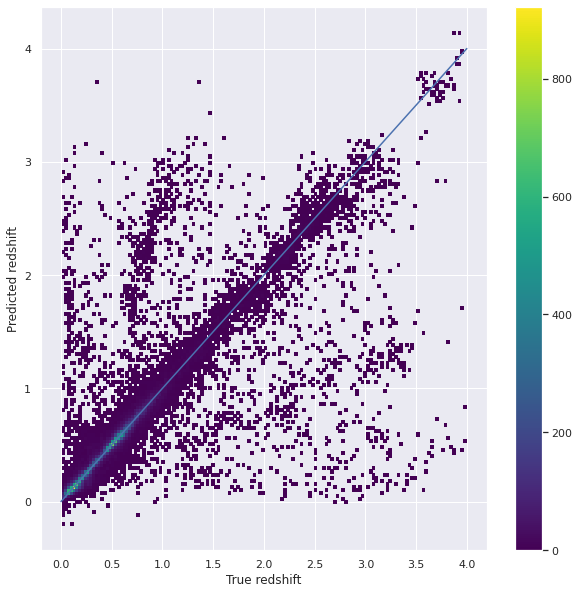

In [37]:
plot_predictions(y_pred, y_test)

In [38]:
metrics = get_point_metrics(pd.Series(y_pred), pd.Series(y_test))

In [39]:
metrics

,zspec_bin,count,L,bias_bw,bias_conv,scatter_bw,scatter_conv,outlier_bw,outlier_conv,mse
0,"(0.0, 4.0]",42960,0.092342,0.001236,0.001622,0.030077,0.025085,0.151909,0.061336,0.099928


In [40]:
df = pd.DataFrame(y_pred, columns=['photoz'])
df['photz_err'] = np.ravel(std_arr)
df['specz'] = y_test
df['object_id'] = OID_test
if os.path.exists(f'/predictions/{model_name}') == False:
    os.makedirs(f'/predictions/{model_name}')
    
df.to_csv(f'/predictions/{model_name}/testing_predictions.csv', index=False)

In [41]:
if os.path.exists(f'predictions/{model_name}') ==  False:
    os.makedirs(f'predictions/{model_name}')
    
metrics.to_csv(f'/predictions/{model_name}/testing_metrics.csv', index=False)

In [42]:
y_train

0         2.17865
1         0.84550
2         0.44850
3         0.37001
4         0.58149
           ...   
200476    1.86393
200477    0.89864
200478    0.24194
200479    0.77584
200480    1.06695
Name: specz_redshift, Length: 200481, dtype: float64